<a href="https://colab.research.google.com/github/N-nolwenn/Remote_Sensing_Image_Analysis/blob/main/OEM_mini_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OpenEarhMap Semantinc Segmentation

original implementation found at https://github.com/bao18/open_earth_map/blob/main/Demo.ipynb

---

### Requirements

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!git clone https://github.com/bao18/open_earth_map.git '/content/drive/My Drive/Colab/OEM/' # <= change path where you save code

fatal: destination path '/content/drive/My Drive/Colab/OEM' already exists and is not an empty directory.


In [2]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 57.5 MB/s eta 0:00:00


In [3]:
import gdown
import zipfile

url = "https://drive.google.com/uc?export=download&confirm=pbef&id=1SqLqv1RCJdiUFnnfIce78M9nJF_KF11U"
output = "/content/drive/My Drive/Colab/OEM/OpenEathMap_Mini.zip" # <= change path where you save data
gdown.download(url, output, quiet=False)

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?export=download&confirm=pbef&id=1SqLqv1RCJdiUFnnfIce78M9nJF_KF11U 



In [6]:
!unzip -q "/content/drive/MyDrive/Colab/OEM/OpenEarthMap_Mini.zip" -d "/content/drive/My Drive/Colab/OEM/" # <= change path where you save data

### Import
---

In [7]:
!pip install oem

In [8]:
import os
import time
import warnings
import numpy as np
import torch
import torchvision
from pathlib import Path
import matplotlib.pyplot as plt
import sys
sys.path.append('/content/drive/My Drive/Colab/OEM') # <= change path where you save code
import oem

warnings.filterwarnings("ignore")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Define main parameters

In [9]:
# Path to the OpenEarthMap directory
OEM_DATA_DIR = "/content/drive/My Drive/Colab/OEM/OpenEarthMap_Mini/"

# Training and validation file list
TRAIN_LIST = os.path.join(OEM_DATA_DIR, "train.txt")
VAL_LIST = os.path.join(OEM_DATA_DIR, "val.txt")

IMG_SIZE = 512
N_CLASSES = 9
LR = 0.0001
BATCH_SIZE = 4
NUM_EPOCHS = 30
DEVICE = "cuda"
OUTPUT_DIR = "/content/drive/My Drive/Colab/OEM/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

### Prepare training and validation file lists.

In [10]:
img_paths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/images/" in str(f)]
train_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TRAIN_LIST, dtype=str)]
val_fns = [str(f) for f in img_paths if f.name in np.loadtxt(VAL_LIST, dtype=str)]

print("Total samples      :", len(img_paths))
print("Training samples   :", len(train_fns))
print("Validation samples :", len(val_fns))

Total samples      : 1068
Training samples   : 663
Validation samples : 92


In [17]:
cd /content/drive/My Drive/Colab/OEM/OpenEarthMap_Mini

[Errno 2] No such file or directory: '/content/drive/My Drive/Colab/OEM/OpenEarthMap_Mini'
/content


In [14]:
# Path to the OpenEarthMap directory
OEM_DATA_DIR = "/content/drive/My Drive/Colab/OEM/OpenEarthMap_Mini/"

# Training and validation file list
TRAIN_LIST = os.path.join(OEM_DATA_DIR, "subdirectory", "train.txt")
VAL_LIST = os.path.join(OEM_DATA_DIR, "subdirectory", "val.txt")

# Find all ".tif" files in the "images" subdirectories
img_paths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "images" in str(f)]

# Get the filenames from the training and validation file lists
train_filenames = np.loadtxt(TRAIN_LIST, dtype=str)
val_filenames = np.loadtxt(VAL_LIST, dtype=str)

# Filter the ".tif" files based on whether they are in the training or validation set
train_fns = [str(f) for f in img_paths if f.stem in train_filenames]
val_fns = [str(f) for f in img_paths if f.stem in val_filenames]

print("Total samples      :", len(img_paths))
print("Training samples   :", len(train_fns))
print("Validation samples :", len(val_fns))


FileNotFoundError: /content/drive/My Drive/Colab/OEM/OpenEarthMap_Mini/subdirectory/train.txt not found.

### Prepare training and validation augmentations.

In [ ]:
train_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Rotate(),
        oem.transforms.Crop(IMG_SIZE),
    ],
)

val_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Resize(IMG_SIZE),
    ],
)

### Define training and validation dataloaders

In [ ]:
train_data = oem.dataset.OpenEarthMapDataset(
    train_fns,
    n_classes=N_CLASSES,
    augm=train_augm,
)

val_data = oem.dataset.OpenEarthMapDataset(
    val_fns,
    n_classes=N_CLASSES,
    augm=val_augm,
)

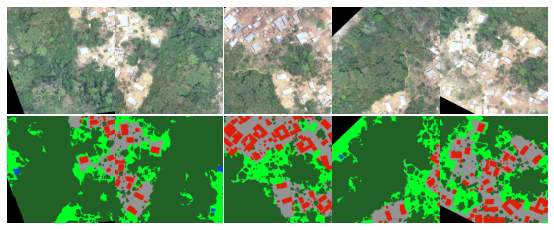

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(5*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

IDX = 1
for i in range(5):
    img, msk, fn = train_data[IDX]

    img = np.moveaxis(img.numpy(), 0, -1)
    msk = oem.utils.make_rgb(np.argmax(msk.numpy(), axis=0))

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(msk)
    axs[1, i].axis("off")

plt.show()

In [ ]:
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=True,
    drop_last=True,
)
val_data_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=False,
)

### Define the network architecture, optimizer, and criterion

In [ ]:
network = oem.networks.UNet(in_channels=3, n_classes=N_CLASSES)
optimizer = torch.optim.Adam(network.parameters(), lr=LR)
criterion = oem.losses.JaccardLoss()

### Train and validate the network

In [ ]:
start = time.time()

max_score = 0
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch: {epoch + 1}")

    train_logs = oem.runners.train_epoch(
        model=network,
        optimizer=optimizer,
        criterion=criterion,
        dataloader=train_data_loader,
        device=DEVICE,
    )

    valid_logs = oem.runners.valid_epoch(
        model=network,
        criterion=criterion,
        dataloader=val_data_loader,
        device=DEVICE,
    )
    epoch_score = valid_logs["Score"]
    if max_score < epoch_score:
        max_score = epoch_score
        oem.utils.save_model(
            model=network,
            epoch=epoch,
            best_score=max_score,
            model_name="model.pth",
            output_dir=OUTPUT_DIR,
        )

print("Elapsed time: {:.3f} min".format((time.time() - start) / 60.0))


Epoch: 1


Valid: 100%|██████████| 23/23 [00:21<00:00,  1.09it/s, Loss=6.73, Score=0.0936]


model saved

Epoch: 2


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.59it/s, Loss=6.46, Score=0.116]


model saved

Epoch: 3


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.62it/s, Loss=6.31, Score=0.132]


model saved

Epoch: 4


Valid: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, Loss=6.32, Score=0.13]



Epoch: 5


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, Loss=6.19, Score=0.143]


model saved

Epoch: 6


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.55it/s, Loss=6.18, Score=0.143]


model saved

Epoch: 7


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.57it/s, Loss=6.2, Score=0.14]



Epoch: 8


Valid: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, Loss=6.06, Score=0.153]


model saved

Epoch: 9


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.58it/s, Loss=6.02, Score=0.158]


model saved

Epoch: 10


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, Loss=5.95, Score=0.166]


model saved

Epoch: 11


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.60it/s, Loss=5.91, Score=0.167]


model saved

Epoch: 12


Valid: 100%|██████████| 23/23 [00:15<00:00,  1.53it/s, Loss=5.82, Score=0.178]


model saved

Epoch: 13


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.57it/s, Loss=6.0, Score=0.162]



Epoch: 14


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.59it/s, Loss=5.87, Score=0.174]



Epoch: 15


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, Loss=5.93, Score=0.168]



Epoch: 16


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, Loss=5.85, Score=0.175]



Epoch: 17


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.61it/s, Loss=5.69, Score=0.19]


model saved

Epoch: 18


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.60it/s, Loss=6.0, Score=0.164]



Epoch: 19


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.60it/s, Loss=5.9, Score=0.173]



Epoch: 20


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.57it/s, Loss=5.69, Score=0.189]



Epoch: 21


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.57it/s, Loss=5.61, Score=0.199]


model saved

Epoch: 22


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.59it/s, Loss=5.51, Score=0.21]


model saved

Epoch: 23


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.59it/s, Loss=5.57, Score=0.203]



Epoch: 24


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, Loss=5.68, Score=0.19]



Epoch: 25


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, Loss=5.58, Score=0.2]



Epoch: 26


Valid: 100%|██████████| 23/23 [00:16<00:00,  1.42it/s, Loss=5.64, Score=0.196]



Epoch: 27


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.59it/s, Loss=5.44, Score=0.216]


model saved

Epoch: 28


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.59it/s, Loss=5.5, Score=0.209]



Epoch: 29


Valid: 100%|██████████| 23/23 [00:15<00:00,  1.51it/s, Loss=5.46, Score=0.213]



Epoch: 30


Valid: 100%|██████████| 23/23 [00:14<00:00,  1.58it/s, Loss=5.49, Score=0.211]

Elapsed time: 92.562 min


# Testing

### Prepare testing files

In [ ]:
TEST_LIST = os.path.join(OEM_DATA_DIR, "test.txt")

img_paths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/images/" in str(f)]
test_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TEST_LIST, dtype=str)]

print("Total samples   :", len(img_paths))
print("Testing samples :", len(test_fns))

Total samples   : 1068
Testing samples : 313


### Define test dataloader

In [ ]:
test_data = oem.dataset.OpenEarthMapDataset(test_fns, n_classes=N_CLASSES, augm=None, testing=True)

### Load trained network

In [ ]:
network = oem.networks.UNet(in_channels=3, n_classes=N_CLASSES)
network = oem.utils.load_checkpoint(network, model_name="model.pth", model_dir=OUTPUT_DIR)

Loaded model:model.pth (Epoch=26, Score=0.216)


### Visualize predictions

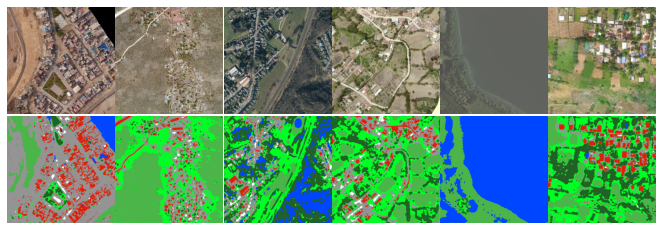

In [ ]:
# visualize predictions
NPLOT = 6
idxs = np.argsort(np.random.rand(len(test_fns)))[:NPLOT]

fig, axs = plt.subplots(2, NPLOT, figsize=(NPLOT*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

network.eval().to(DEVICE)
for i, idx in enumerate(idxs):
    img, *_ = test_data[idx]

    with torch.no_grad():
        prd = network(img.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()

    img = np.moveaxis(img.numpy(), 0, -1)
    prd = oem.utils.make_rgb(np.argmax(prd.numpy(), axis=0))

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(prd)
    axs[1, i].axis("off")
plt.show()

### Save predictions in png files

In [ ]:
import math
from PIL import Image

PR_DIR = "/content/drive/My Drive/Colab/OEM/png" # <= change path where you save predictions
os.makedirs(PR_DIR, exist_ok=True)

save_fns = []

network.eval().to(DEVICE)
for test_fn in test_fns:
    img = Image.fromarray(oem.dataset.load_multiband(test_fn))

    w, h = img.size[:2]
    power_h = math.ceil(np.log2(h) / np.log2(2))
    power_w = math.ceil(np.log2(w) / np.log2(2))
    if 2**power_h != h or 2**power_w != w:
      img = img.resize((2**power_w, 2**power_h), resample=Image.BICUBIC)
    img = np.array(img)

    # test time augmentation
    imgs = []
    imgs.append(img.copy())
    imgs.append(img[:, ::-1, :].copy())
    imgs.append(img[::-1, :, :].copy())
    imgs.append(img[::-1, ::-1, :].copy())

    input = torch.cat([torchvision.transforms.functional.to_tensor(x).unsqueeze(0) for x in imgs], dim=0).float().to(DEVICE)

    pred = []
    with torch.no_grad():
      msk = network(input)
      msk = torch.softmax(msk[:, :, ...], dim=1)
      msk = msk.cpu().numpy()
      pred = (msk[0, :, :, :] + msk[1, :, :, ::-1] + msk[2, :, ::-1, :] + msk[3, :, ::-1, ::-1])/4

    pred = Image.fromarray(pred.argmax(axis=0).astype("uint8"))
    y_pr = pred.resize((w, h), resample=Image.NEAREST)

    filename = os.path.basename(test_fn).replace('tif','png')
    save_fn = os.path.join(PR_DIR, filename)
    y_pr.save(save_fn)
    save_fns.append(save_fn)